<a href="https://colab.research.google.com/github/89agnes/arima-ltsm/blob/main/lstm_arima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [257]:
# Mengunduh data harga saham ADRO.JK dari Yahoo Finance
start_date = '2023-11-11'
end_date = '2024-11-10'
data = yf.download('ADRO.JK', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [258]:
# Menampilkan data
print(data.head())

Price                        Adj Close   Close    High     Low    Open  \
Ticker                         ADRO.JK ADRO.JK ADRO.JK ADRO.JK ADRO.JK   
Date                                                                     
2023-11-13 00:00:00+00:00  2120.923340  2480.0  2510.0  2450.0  2490.0   
2023-11-14 00:00:00+00:00  2120.923340  2480.0  2520.0  2450.0  2480.0   
2023-11-15 00:00:00+00:00  2146.579590  2510.0  2560.0  2490.0  2520.0   
2023-11-16 00:00:00+00:00  2163.683838  2530.0  2530.0  2470.0  2510.0   
2023-11-17 00:00:00+00:00  2172.235840  2540.0  2550.0  2500.0  2500.0   

Price                        Volume  
Ticker                      ADRO.JK  
Date                                 
2023-11-13 00:00:00+00:00  20144700  
2023-11-14 00:00:00+00:00  37330100  
2023-11-15 00:00:00+00:00  33971500  
2023-11-16 00:00:00+00:00  18745300  
2023-11-17 00:00:00+00:00  17834500  


In [259]:
# Menghapus nilai yang hilang
data.dropna(inplace=True)

In [260]:
# Menggunakan hanya kolom 'Close'
data = data[['Close']]
data = data.dropna()

In [261]:
#  Mengubah tipe data jika diperlukan
# Misalnya, memastikan kolom 'Close' adalah float
data['Close'] = data['Close'].astype(float)

In [262]:
# Menampilkan data Close dari tanggal terakhir
last_date = data.index[-1]  # Mendapatkan tanggal terakhir
last_close = data.loc[last_date, 'Close']  # Mengambil harga penutupan pada tanggal terakhir

print(f"Harga Penutupan pada {last_date.date()}: {last_close}")

Harga Penutupan pada 2024-11-08: Ticker
ADRO.JK    3830.0
Name: 2024-11-08 00:00:00+00:00, dtype: float64


In [263]:
# Mengatur indeks waktu
data.index = pd.to_datetime(data.index)

In [264]:
# Menampilkan informasi data setelah pembersihan
print("\nData Setelah Pembersihan:")
print(data.info())
print(data.head())


Data Setelah Pembersihan:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 237 entries, 2023-11-13 00:00:00+00:00 to 2024-11-08 00:00:00+00:00
Data columns (total 1 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Close, ADRO.JK)  237 non-null    float64
dtypes: float64(1)
memory usage: 11.8 KB
None
Price                       Close
Ticker                    ADRO.JK
Date                             
2023-11-13 00:00:00+00:00  2480.0
2023-11-14 00:00:00+00:00  2480.0
2023-11-15 00:00:00+00:00  2510.0
2023-11-16 00:00:00+00:00  2530.0
2023-11-17 00:00:00+00:00  2540.0


In [265]:
# Membagi data menjadi data training dan testing
train_size = int(len(data) * 0.7)
train_data = data[:train_size]
test_data = data[train_size:]

In [266]:
train_data.head()

Price,Close
Ticker,ADRO.JK
Date,
2023-11-13 00:00:00+00:00,2480.0
2023-11-14 00:00:00+00:00,2480.0
2023-11-15 00:00:00+00:00,2510.0
2023-11-16 00:00:00+00:00,2530.0
2023-11-17 00:00:00+00:00,2540.0


In [267]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [268]:
# Membuat dataset untuk LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [269]:

time_step = 60  # Menggunakan 60 hari sebelumnya untuk prediksi
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

In [270]:
# Mengubah bentuk input untuk LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [271]:
# Membangun model LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [272]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.1402
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0341
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0323
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0140
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0192
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0210
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0114
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0185
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0133
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0139
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0129
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0107
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0140
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0164
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0157
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━

In [273]:
# Prediksi
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [274]:
# Mengembalikan nilai ke skala asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [275]:
# Menghitung RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 2748.662718579578
Test RMSE: 3719.0473253280666


In [282]:
# Mengubah prediksi kembali ke skala asli
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [288]:
# Akurasi
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
accuracy = 100 - (rmse / np.mean(y_test_inv)) * 100
print(f'Akurasi: {accuracy:.2f}%')

Akurasi: 87.98%


In [291]:
# Calculate MSE
mse = mean_squared_error(y_test, scaler.inverse_transform(y_test.reshape(-1, 1)))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 14313913.502656918


In [292]:
# Menampilkan hasil data training dan testing untuk LSTM
results_lstm = pd.DataFrame({
    'Actual': np.concatenate((y_train.flatten(), y_test.flatten())), # Flatten y_train and y_test
    'LSTM_Predicted': np.concatenate((train_predict.flatten(), test_predict.flatten())) # Flatten train_predict and test_predict
})

In [294]:
print(results_lstm)

       Actual  LSTM_Predicted
0    0.146067    1.957232e+09
1    0.157303    1.962758e+09
2    0.191011    1.968762e+09
3    0.202247    1.976192e+09
4    0.101124    1.984395e+09
..        ...             ...
110  1.629213    2.910356e+09
111  1.786517    2.911929e+09
112  1.910112    2.928791e+09
113  1.876404    2.958681e+09
114  1.775281    2.989800e+09

[115 rows x 2 columns]


In [295]:
from sklearn.metrics import mean_absolute_percentage_error

In [296]:
from sklearn.metrics import mean_absolute_percentage_error

# y_test and test_predict are your actual and predicted values, respectively
mape = mean_absolute_percentage_error(y_test_inv, test_predict)
print(f'MAPE: {mape}')

MAPE: 781133.6392222085


In [426]:
accuracy_percentage = 100 - (mape * 100)
print(f'Akurasi Persentase MAPE LSTM: {accuracy_percentage:.2f}%')

Akurasi Persentase MAPE LSTM: -78113263.92%


In [298]:
# import the r2_score function from sklearn.metrics
from sklearn.metrics import r2_score

# Menghitung R-squared untuk LSTM
r2_lstm = r2_score(y_test, test_predict)
r2_lstm_percentage = r2_lstm * 100
print(f'R-squared LSTM: {r2_lstm_percentage:.2f}%')

R-squared LSTM: -28623994827528896249856.00%


In [299]:
from sklearn.preprocessing import MinMaxScaler

fit_transform digunakan pada data training untuk menghitung parameter scaling (minimum dan maksimum) dan kemudian menerapkan scaling pada data tersebut.

transform digunakan pada data testing untuk menerapkan scaling menggunakan parameter yang telah dihitung dari data training. Ini penting agar data testing discaling dengan cara yang konsisten dengan data training.

In [300]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [301]:
# Normalisasi data training
train_scaled = scaler.fit_transform(train_data)

# Normalisasi data testing
test_scaled = scaler.transform(test_data)

In [302]:
# Normalisasi data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [303]:
# Combine scaled training and testing data
scaled_data = np.concatenate([train_scaled, test_scaled])

In [304]:
# Mengambil data terakhir untuk prediksi 7 hari ke depan
last_data = scaled_data[-time_step:]
last_data = last_data.reshape(1, time_step, 1)

In [305]:
# Melakukan prediksi 7 hari ke depan
future_predictions = []
for _ in range(7):
    next_pred = model.predict(last_data)
    future_predictions.append(next_pred[0, 0])
    last_data = np.append(last_data[:, 1:, :], next_pred.reshape(1, 1, 1), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [306]:

# Menginverse transformasi prediksi
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [307]:
# Menampilkan hasil prediksi
print("Prediksi Harga Saham ADRO 7 Hari ke Depan:")
for i, price in enumerate(future_predictions):
    print(f"Hari {i+1}: {price[0]:.2f}")

Prediksi Harga Saham ADRO 7 Hari ke Depan:
Hari 1: 3815.70
Hari 2: 3821.26
Hari 3: 3822.21
Hari 4: 3820.56
Hari 5: 3817.43
Hari 6: 3813.46
Hari 7: 3809.02


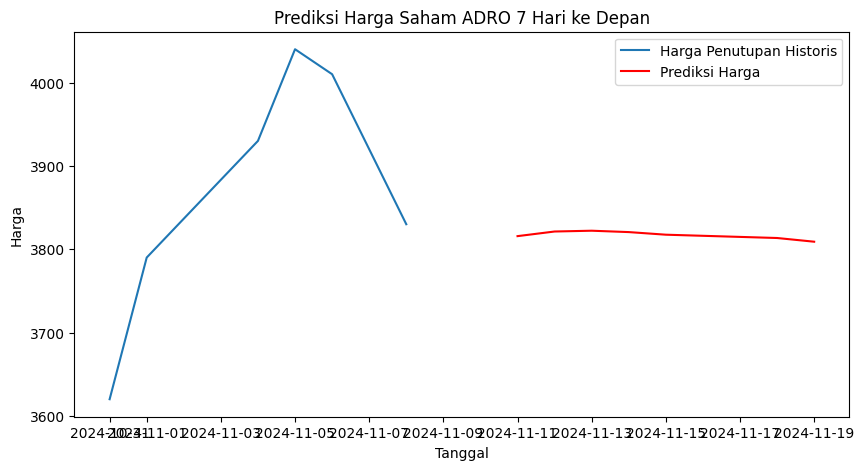

In [308]:
# (Opsional) Menampilkan grafik prediksi
plt.figure(figsize=(10, 5))
plt.plot(data.index[-len(future_predictions):], data['Close'].values[-len(future_predictions):], label='Harga Penutupan Historis')
plt.plot(pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7, freq='B'), future_predictions, label='Prediksi Harga', color='red')
plt.title('Prediksi Harga Saham ADRO 7 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

test acf

In [309]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [310]:
# Mengunduh data harga saham ADRO.JK dari Yahoo Finance
start_date = '2023-11-11'
end_date = '2024-11-10'
data = yf.download('ADRO.JK', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [368]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

# Mengunduh data harga saham ADRO.JK dari Yahoo Finance
start_date = '2023-11-11'
end_date = '2024-11-10'
data = yf.download('ADRO.JK', start=start_date, end=end_date)

# Check if the downloaded data is empty
if data.empty:
    print("Error: Downloaded data is empty. Check ticker symbol and date range.")
else:
    # Mengambil kolom 'Close' dan membersihkan data
    data = data[['Close']]
    data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [363]:
# Fungsi untuk uji stasionaritas dengan Augmented Dickey-Fuller (ADF)
def test_stationarity(timeseries):
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p-value', 'Used Lag', 'Number of Observations'])
    for key, value in adf_test[4].items():
        adf_output[f'Critical Value ({key})'] = value
    return adf_output

In [373]:
# Melakukan uji stasionaritas pada data asli
stationarity_result = test_stationarity(data)
print("Hasil Uji Stasionaritas Data Asli:")
print(stationarity_result)

Hasil Uji Stasionaritas Data Asli:
Test Statistic              0.409512
p-value                     0.981847
Used Lag                    5.000000
Number of Observations    231.000000
Critical Value (1%)        -3.458980
Critical Value (5%)        -2.874135
Critical Value (10%)       -2.573482
dtype: float64


In [374]:
# Jika p-value > 0.05, data tidak stasioner
if stationarity_result['p-value'] > 0.05:
    print("Data tidak stasioner, melakukan differencing...")
    # Changed 'data_close' to 'data'
    data, stationarity_result_diff = make_stationary(data)
    print("Hasil Uji Stasionaritas Setelah Differencing:")
    print(stationarity_result_diff)

Data tidak stasioner, melakukan differencing...
Hasil Uji Stasionaritas Setelah Differencing:
Test Statistic           -1.746505e+01
p-value                   4.575115e-30
Used Lag                  0.000000e+00
Number of Observations    2.350000e+02
Critical Value (1%)      -3.458487e+00
Critical Value (5%)      -2.873919e+00
Critical Value (10%)     -2.573367e+00
dtype: float64


In [376]:
# Jika data tidak stasioner, kita perlu melakukan differencing
if stationarity_result['p-value'] > 0.05:
    print("Data tidak stasioner, melakukan differencing...")
    data_diff = data.diff().dropna()
else:
    print("Data sudah stasioner.")
    data_diff = data

Data tidak stasioner, melakukan differencing...


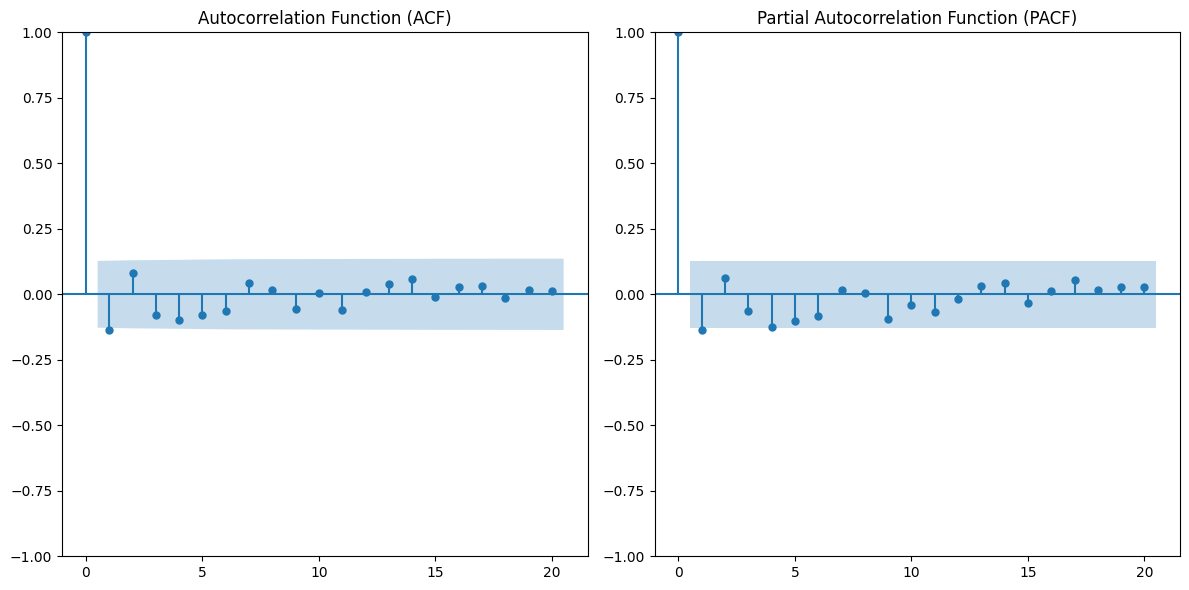

In [377]:
# Menampilkan grafik ACF dan PACF untuk menentukan p dan q
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(data['Close'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')
plt.subplot(1, 2, 2)
plot_pacf(data['Close'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()

In [378]:
# Menentukan p dan q berdasarkan grafik ACF dan PACF
# Anda dapat mengamati grafik dan menentukan nilai p dan q secara manual
p = int(input("Masukkan nilai p (dari grafik PACF): "))
q = int(input("Masukkan nilai q (dari grafik ACF): "))

Masukkan nilai p (dari grafik PACF): 1
Masukkan nilai q (dari grafik ACF): 1


In [379]:
print(f"\nParameter ARIMA yang ditentukan: p={p}, d={d}, q={q}")


Parameter ARIMA yang ditentukan: p=1, d=1, q=1


**ARIMA**

In [ ]:
# Membagi data menjadi set pelatihan dan pengujian
train_size = int(len(data) * 0.7)
train_data = data['Close'][:train_size]
test_data = data['Close'][train_size:]

In [380]:
# Model ARIMA
# Menggunakan data training untuk ARIMA
model_arima = ARIMA(train_data, order=(1, 0, 1))
model_arima_fit = model_arima.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [381]:
# Menampilkan ringkasan model
print(model_arima_fit.summary()) # Use model_arima_fit instead of model_arima

                               SARIMAX Results                                
Dep. Variable:          Close_ADRO.JK   No. Observations:                  165
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -878.725
Date:                Tue, 12 Nov 2024   AIC                           1765.450
Time:                        09:19:19   BIC                           1777.873
Sample:                             0   HQIC                          1770.493
                                - 165                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2659.5625    254.091     10.467      0.000    2161.552    3157.573
ar.L1          0.9859      0.021     46.390      0.000       0.944       1.028
ma.L1         -0.0355      0.076     -0.469      0.6

In [382]:
# Melakukan prediksi
predictions = model_arima_fit.forecast(steps=len(test_data))
predictions = pd.Series(predictions, index=test_data.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


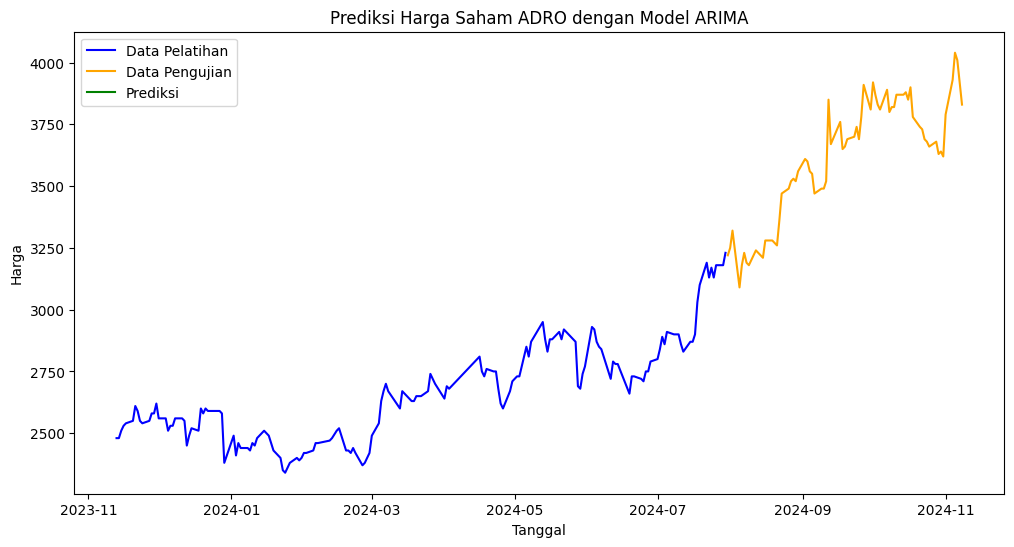

In [385]:
# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Data Pelatihan', color='blue')
plt.plot(test_data, label='Data Pengujian', color='orange')
plt.plot(predictions, label='Prediksi', color='green')
plt.title('Prediksi Harga Saham ADRO dengan Model ARIMA')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.show()

MSE: Mengukur rata-rata kuadrat kesalahan antara nilai aktual dan nilai prediksi.
R-squared: Mengukur proporsi variabilitas dalam data yang dapat dijelaskan oleh model. Nilai R-squared berkisar antara 0 hingga 1, di mana nilai yang lebih tinggi menunjukkan model yang lebih baik.

In [387]:
# Menghitung MSE untuk ARIMA
# Call the forecast method with the desired number of steps (len(test_data) in this case)
predictions = model_arima_fit.forecast(steps=len(test_data))
mse_arima = mean_squared_error(test_data.values, predictions)  # Use the predictions variable
print(f'MSE ARIMA: {mse_arima}')

MSE ARIMA: 471074.34792006057


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [388]:
# Menghitung MSE dan R-squared untuk ARIMA
# Replace 'arima_forecast' with 'predictions' to use the calculated predictions
mse_arima = mean_squared_error(test_data.values, predictions)
r2_arima = r2_score(test_data.values, predictions)
print(f'MSE ARIMA: {mse_arima}')
print(f'R-squared ARIMA: {r2_arima}')

MSE ARIMA: 471074.34792006057
R-squared ARIMA: -6.7902873467417795


In [389]:
# Menampilkan hasil
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 454.46583406418245


In [392]:
# Melatih model ARIMA
model = ARIMA(train_data, order=(1, 1, 1))  # Menggunakan differencing pertama
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

In [417]:
# Melakukan prediksi pada data testing
predictions = model_fit.forecast(steps=len(test_data))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [418]:
# Menghitung akurasi menggunakan MAE dan RMSE
mae = mean_absolute_error(test_data, predictions)
rmse = np.sqrt(mean_squared_error(test_data, predictions))

In [396]:
# Menampilkan hasil
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 390.27517489087813
Root Mean Squared Error (RMSE): 454.46583406418245


In [423]:
from sklearn.metrics import mean_absolute_percentage_error

#test_data' contains the actual values and 'predictions' contains the predicted values
mape_arima = mean_absolute_percentage_error(test_data, predictions)

print(f'MAPE ARIMA: {mape_arima}')

MAPE ARIMA: 0.104179671287901


In [425]:
accuracy_arima = 100 - mape_arima * 100

print(f'Akurasi ARIMA: {accuracy_arima:.2f}%')

Akurasi ARIMA: 89.58%


In [397]:
mean_actual = np.mean(test_data)

In [398]:
accuracy_percentage = 100 - (rmse / mean_actual) * 100

In [399]:
# Menghitung akurasi persenan RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))
mean_actual = np.mean(test_data)
accuracy_percentage = 100 - (rmse / mean_actual) * 100

print(f"Akurasi Persenan RMSE ARIMA: {accuracy_percentage:.2f}%")

Akurasi Persenan RMSE ARIMA: 87.41%


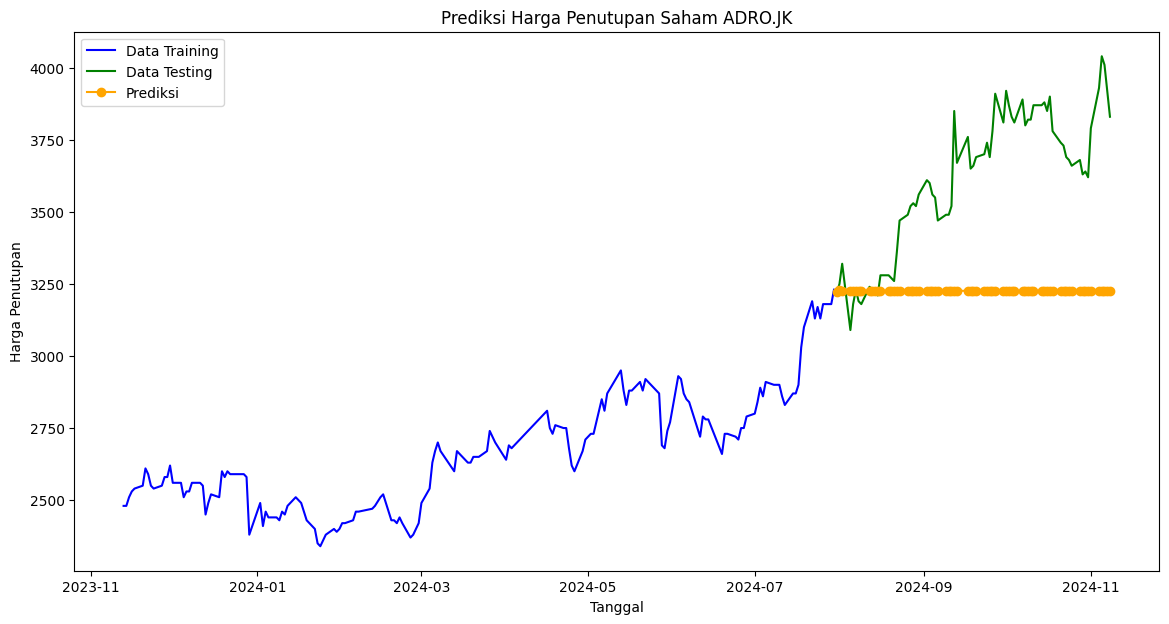

In [402]:
# Visualisasi hasil prediksi
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data, label='Data Training', color='blue')
plt.plot(test_data.index, test_data, label='Data Testing', color='green') # Changed test to test_data for the x-axis
plt.plot(test_data.index, predictions, label='Prediksi', color='orange', marker='o') # Changed test to test_data for the x-axis
plt.title('Prediksi Harga Penutupan Saham ADRO.JK')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()

In [403]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression

In [404]:
# Mengunduh data harga saham ADRO.JK dari Yahoo Finance
start_date = '2023-11-11'
end_date = '2024-11-10'
data = yf.download('ADRO.JK', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [405]:
# Mengatur kolom tanggal sebagai indeks
data.reset_index(inplace=True)  # Mengatur ulang indeks jika diperlukan
data.set_index('Date', inplace=True)  # Mengatur kolom 'Date' sebagai indeks

In [406]:
# Menambahkan kolom 'end_date' ke DataFrame
data['end_date'] = end_date

In [407]:
# Menampilkan DataFrame setelah mengatur indeks
print("\nData setelah mengatur indeks:")
print(data.head())


Data setelah mengatur indeks:
Price                        Adj Close   Close    High     Low    Open  \
Ticker                         ADRO.JK ADRO.JK ADRO.JK ADRO.JK ADRO.JK   
Date                                                                     
2023-11-13 00:00:00+00:00  2120.923340  2480.0  2510.0  2450.0  2490.0   
2023-11-14 00:00:00+00:00  2120.923340  2480.0  2520.0  2450.0  2480.0   
2023-11-15 00:00:00+00:00  2146.579590  2510.0  2560.0  2490.0  2520.0   
2023-11-16 00:00:00+00:00  2163.683838  2530.0  2530.0  2470.0  2510.0   
2023-11-17 00:00:00+00:00  2172.235840  2540.0  2550.0  2500.0  2500.0   

Price                        Volume    end_date  
Ticker                      ADRO.JK              
Date                                             
2023-11-13 00:00:00+00:00  20144700  2024-11-10  
2023-11-14 00:00:00+00:00  37330100  2024-11-10  
2023-11-15 00:00:00+00:00  33971500  2024-11-10  
2023-11-16 00:00:00+00:00  18745300  2024-11-10  
2023-11-17 00:00:00+00:00 

In [408]:
# Menampilkan data Close dari tanggal terakhir
last_date = data.index[-1]  # Mendapatkan tanggal terakhir
last_close = data.loc[last_date, 'Close']  # Mengambil harga penutupan pada tanggal terakhir

print(f"Harga Penutupan pada {last_date.date()}: {last_close}")

Harga Penutupan pada 2024-11-08: Ticker
ADRO.JK    3830.0
Name: 2024-11-08 00:00:00+00:00, dtype: object


In [409]:
# Menggunakan harga penutupan untuk prediksi
data['Days'] = np.arange(len(data))  # Membuat fitur untuk hari
X = data[['Days']]  # Fitur
y = data['Close']  # Target

In [410]:
# Membuat model regresi linier
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [411]:
# Memprediksi harga untuk 7 hari ke depan
future_days = np.array([[len(data) + i] for i in range(1, 8)])  # Hari ke-1 sampai ke-7
predictions = model.predict(future_days)

In [412]:
# Menampilkan hasil prediksi
predicted_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=7)
predicted_prices = pd.DataFrame(predictions, index=predicted_dates, columns=['Predicted Close'])


In [413]:

print("\nPrediksi Harga Penutupan untuk 7 Hari ke Depan:")
print(predicted_prices)



Prediksi Harga Penutupan untuk 7 Hari ke Depan:
                           Predicted Close
2024-11-09 00:00:00+00:00      3728.500706
2024-11-10 00:00:00+00:00      3735.006848
2024-11-11 00:00:00+00:00      3741.512990
2024-11-12 00:00:00+00:00      3748.019131
2024-11-13 00:00:00+00:00      3754.525273
2024-11-14 00:00:00+00:00      3761.031414
2024-11-15 00:00:00+00:00      3767.537556


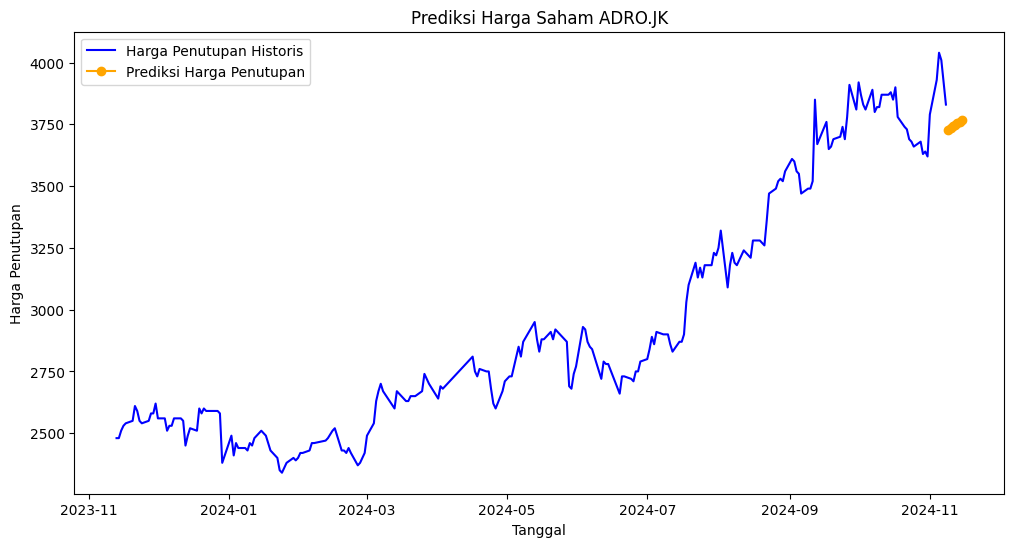

In [414]:
# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Harga Penutupan Historis', color='blue')
plt.plot(predicted_prices, label='Prediksi Harga Penutupan', color='orange', marker='o')
plt.title('Prediksi Harga Saham ADRO.JK')
plt.xlabel('Tanggal')
plt.ylabel('Harga Penutupan')
plt.legend()
plt.show()